In [1]:
import zipfile
import os
import random
from PIL import Image
from PIL import ImageEnhance
import json
import torch

In [2]:
from pylab import *
def ploting(name,x,y):
    plt.rcParams['figure.figsize'] = (12.0, 8.0) 
    plt.plot(x, y, 'ro-', color='#4169E1', alpha=0.8, label=name)
    plt.legend(loc="upper right")
    plt.xlabel('iter')
    plt.ylabel(name)
    plt.show()

In [3]:
# define intitial path
target_path="/kaggle/input/weibo-dataset"

# read the file
rumor_class_dirs = os.listdir(target_path+"/Chinese_Rumor_Dataset-master/CED_Dataset/rumor-repost/")
non_rumor_class_dirs = os.listdir(target_path+"/Chinese_Rumor_Dataset-master/CED_Dataset/non-rumor-repost/")
original_microblog = target_path+"/Chinese_Rumor_Dataset-master/CED_Dataset/original-microblog/"

# pin the label of if rumor
rumor_label="0"
non_rumor_label="1"

rumor_num = 0
non_rumor_num = 0

# calculate the length of dataset
all_rumor_list = []
all_non_rumor_list = []

# read the data which is totally rumor
for rumor_class_dir in rumor_class_dirs: 
    if(rumor_class_dir != '.DS_Store'):
        # read each data and got the content of it
        with open(original_microblog + rumor_class_dir, 'r') as f:
            rumor_content = f.read()
        rumor_dict = json.loads(rumor_content)
        # put it into the rumor list
        all_rumor_list.append(rumor_label+"\t"+rumor_dict["text"]+"\n")
        rumor_num +=1


# read the data which is not rumor
for non_rumor_class_dir in non_rumor_class_dirs: 
    if(non_rumor_class_dir != '.DS_Store'):
        # read each data
        with open(original_microblog + non_rumor_class_dir, 'r') as f2:
            non_rumor_content = f2.read()
        non_rumor_dict = json.loads(non_rumor_content)
        # put it into the all rumor list
        all_non_rumor_list.append(non_rumor_label+"\t"+non_rumor_dict["text"]+"\n")
        non_rumor_num +=1
        
print("The total number of rumor data is: "+str(rumor_num))
print("The total number of non-rumor data is: "+str(non_rumor_num))

The total number of rumor data is: 1538
The total number of non-rumor data is: 1849


In [4]:
# write all the data into all_data.txt after shuffle
import random

data_list_path="/kaggle/working/"
all_data_path=data_list_path + "all_data.txt"

all_data_list = all_rumor_list + all_non_rumor_list

random.shuffle(all_data_list)

# before generating the txt, we need to empty it
with open(all_data_path, 'w') as f:
    f.seek(0)
    f.truncate() 

# write all the data
with open(all_data_path, 'a') as f:
    for data in all_data_list:
        f.write(data)

Read the data line by line, and store them into list

In [5]:
all_data_with_label = []

with open(os.path.join(data_list_path, 'all_data.txt'), 'r', encoding='utf-8') as f_data:
    lines = f_data.readlines()
for line in lines:
    words = line.split('\t')[-1].replace('\n', '')
    label = line.split('\t')[0]
    all_data_with_label.append((words,int(label)))

all_data_with_label[0]

('【网传李天一案女主角撤诉】据某著名编辑透露，李天一案女主角撤销控诉，已达和解意向。因未满18岁，且当时已醉酒，被重判的可能性极低，经李天一等人家长的奔走，最终联系上女孩父母进行“长谈”，受害人终得到包括落实北京户口、工作及一套住房。#网友：原来京城的户口是可以用来轮奸的！#',
 0)

In [6]:
len(all_data_with_label)

3387

In [7]:
# split the training set and the testing set
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(all_data_with_label, test_size=0.2, random_state=42)
len(train_set),len(test_set)

(2709, 678)

In [8]:
from transformers import BertTokenizer

# loading the dictionary and the word segmentation tool for chinese
# taken each chinese character as a word
token = BertTokenizer.from_pretrained('bert-base-chinese')

# it seems to be one to one
token

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

PreTrainedTokenizer(name_or_path='bert-base-chinese', vocab_size=21128, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [9]:
# collate function
def collate_fn(data):
    # split the sentences and labels
    sents = [i[0] for i in data]
    labels = [i[1] for i in data]

    # encoding, we loading the token of chinese
    # Batch coding
    data = token.batch_encode_plus(batch_text_or_text_pairs=sents,  # this is the sentences 
                                   truncation=True,                 # if exceed the max length, it will be cut
                                   padding='max_length',            # padding zero to the max length
                                   max_length=500,                  # max length of the sentence
                                   return_tensors='pt',             # the type (pythorch or tensorflow) used pt
                                   return_length=True)              # it will contain the length

    # the number after the encoding
    input_ids = data['input_ids']
    # the place where we padding 0 is 0, other with orginial data is 1
    attention_mask = data['attention_mask']
    # since every sentence is one sentence, everything will be 0
    token_type_ids = data['token_type_ids']
    # modify the type of labels
    labels = torch.LongTensor(labels)

#     print(data['length'], data['length'].max())
#     print(labels)

    return input_ids, attention_mask, token_type_ids, labels

# Using small batch training tends to converge to flat minimization
batch_size = 16

# data loader
loader = torch.utils.data.DataLoader(dataset=train_set,             # the input is the training set
                                     batch_size=batch_size,         # the number of data samples captured in one training
                                     collate_fn=collate_fn,         # use the collate function(Merge the data and labels of a batch)
                                     shuffle=True,                  # mix the data
                                     drop_last=True)                # Delete the incomplete last batch

# view the data
for i, (input_ids, attention_mask, token_type_ids,labels) in enumerate(loader):
    break

print(len(loader))
input_ids.shape, attention_mask.shape, token_type_ids.shape, labels

169


(torch.Size([16, 500]),
 torch.Size([16, 500]),
 torch.Size([16, 500]),
 tensor([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]))

In [10]:
from transformers import BertModel

# load the pre-trained model
pretrained = BertModel.from_pretrained('bert-base-chinese')

# we just need to use it but not train it
for param in pretrained.parameters():
    param.requires_grad_(False)

# test for the pretrained data
out = pretrained(input_ids=input_ids,
           attention_mask=attention_mask,
           token_type_ids=token_type_ids)

# 16 batch size for the 500 max length, 768 is the dimension of encoding
out.last_hidden_state.shape

Downloading:   0%|          | 0.00/393M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([16, 500, 768])

In [11]:
# First take the pre training model for calculation, extract the features from the data, 
# and then put the features into the fully connected neural network for calculation

# Feature extraction based on pre training

# Transfer learning through downstream tasks
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Single layer of totally connected neural network(2 means the classes number)
        self.fc = torch.nn.Linear(768, 2)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        with torch.no_grad():
            out = pretrained(input_ids=input_ids,
                       attention_mask=attention_mask,
                       token_type_ids=token_type_ids)
        
        # Only the features of the 0th word need to be used
        # [cls] is used for classification tasks and appears at the 0th index of the bert output
        out = self.fc(out.last_hidden_state[:, 0])

        out = out.softmax(dim=1)

        return out


model = Model()

model(input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids).shape

torch.Size([16, 2])

In [12]:
from transformers import AdamW

# training the model
optimizer = AdamW(model.parameters(), lr=5e-4)
# cross entropy loss as the criterion
criterion = torch.nn.CrossEntropyLoss()

x=[]
y_l=[]
y_a=[]

model.train()
for i, (input_ids, attention_mask, token_type_ids,labels) in enumerate(loader):
    # get the output
    out = model(input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
    # get the loss and minimize it
    loss = criterion(out, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    # save the model for every five times
    if i % 5 == 0:
        out = out.argmax(dim=1)
        accuracy = (out == labels).sum().item() / len(labels)
        torch.save(model,"bert_model.pt")
        
        # for each time, print the accuracy
        print(i, loss.item(), accuracy)

        x.append(i)
        y_l.append(loss.item())
        y_a.append(accuracy)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


0 0.7079732418060303 0.4375
5 0.6734872460365295 0.625
10 0.7166863083839417 0.5
15 0.6650124788284302 0.625
20 0.6301207542419434 0.8125
25 0.6100216507911682 0.6875
30 0.6187005639076233 0.6875
35 0.5914048552513123 0.6875
40 0.5986233353614807 0.6875
45 0.604082465171814 0.625
50 0.6014761924743652 0.75
55 0.6103348135948181 0.75
60 0.5540513396263123 0.8125
65 0.5986306071281433 0.75
70 0.5993694067001343 0.6875
75 0.6079795360565186 0.625
80 0.48610731959342957 0.875
85 0.5841817855834961 0.6875
90 0.47708654403686523 0.875
95 0.5701515674591064 0.625
100 0.589171826839447 0.6875
105 0.5112141370773315 0.875
110 0.5339287519454956 0.8125
115 0.5027205944061279 0.8125
120 0.5224718451499939 0.75
125 0.5925419926643372 0.6875
130 0.4663441777229309 1.0
135 0.41863515973091125 0.9375
140 0.43328556418418884 0.9375
145 0.5699645280838013 0.75
150 0.45524054765701294 0.875
155 0.5250437259674072 0.8125
160 0.5441185235977173 0.75
165 0.5515192747116089 0.8125


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  after removing the cwd from sys.path.


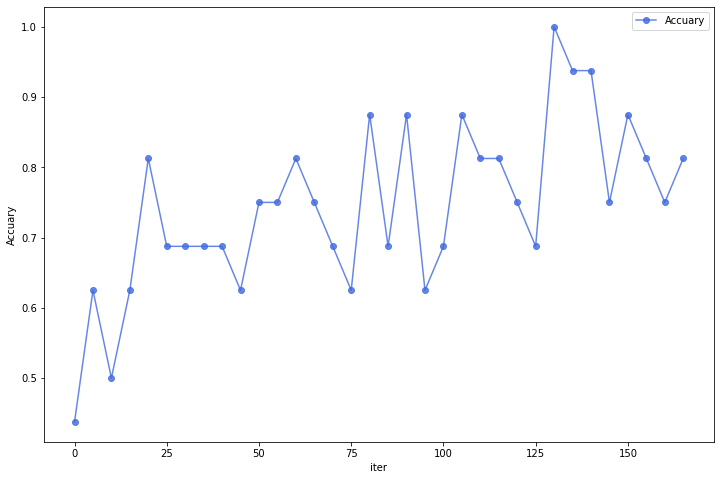

In [13]:
name_a = "Accuary"
name_l = "Loss"
ploting(name_a,x,y_a)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  after removing the cwd from sys.path.


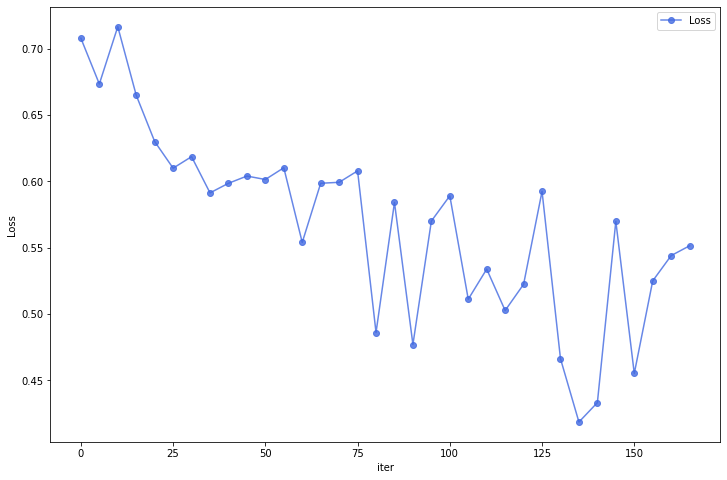

In [14]:
ploting(name_l,x,y_l)

In [15]:
from sklearn import metrics
def performance(y_ture,y_pred):
    print("Accuracy Score is:",metrics.accuracy_score(y_ture, y_pred))
    print("Precision Score is:", metrics.precision_score(y_ture, y_pred))
    print("Recall Score is:",metrics.recall_score(y_ture, y_pred))
    print("F1 Score is:",metrics.f1_score(y_ture, y_pred))
    print("\nConfusion_matrix is:\n",metrics.confusion_matrix(y_ture, y_pred))
    
performance([1,0,1,0,0,1],[1,0,1,0,0,1])

Accuracy Score is: 1.0
Precision Score is: 1.0
Recall Score is: 1.0
F1 Score is: 1.0

Confusion_matrix is:
 [[3 0]
 [0 3]]


In [16]:
# testing the accuarcy
def test(model,if_load):
    y_pred = []
    y_true = []
    if(if_load):
        model = torch.load('/kaggle/input/model-pt/bert_model.pt')
    try:
        model.eval()
    except:
        return -1
    correct = 0
    total = 0
    
    # loading the test set
    loader_test = torch.utils.data.DataLoader(dataset=test_set,
                                              batch_size=32,
                                              collate_fn=collate_fn,
                                              shuffle=True,
                                              drop_last=True)
    
    # use for each
    for i, (input_ids, attention_mask, token_type_ids,labels) in enumerate(loader_test):

#         if i == 2:
#             break

        print(i)
        # get the output by the model
        with torch.no_grad():
            out = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids)
        
        # get the argument max
        out = out.argmax(dim=1)
        # calculate the correct number and the total number
        out_list = out.tolist()
        labels_list = labels.tolist()
        y_pred.extend(out_list)
        y_true.extend(labels_list)
    # print the final Result
    performance(y_true,y_pred)

if_load = 0
test(model,if_load)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
Accuracy Score is: 0.8511904761904762
Precision Score is: 0.8396946564885496
Recall Score is: 0.8991825613079019
F1 Score is: 0.8684210526315788

Confusion_matrix is:
 [[242  63]
 [ 37 330]]
